# Transfer Learning VGG16 using Keras

In [1]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

### Dataset retrived from Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Importing the libraries

In [3]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob

In [4]:
# Re-sizing all the Images 
IMAGE_SIZE = [224, 224]

train_path = '/content/drive/MyDrive/AML/CNN/xray_dataset_covid19/train'
valid_path = '/content/drive/MyDrive/AML/CNN/xray_dataset_covid19/test'


### Import the Vgg 16 library

In [5]:
# Here we will be using imagenet weights

vgg16 = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

58892288/58889256 [==============================] - 4s 0us/step


In [7]:
# don't train existing weights
for layer in vgg16.layers:
    layer.trainable = False

In [8]:
# useful for getting number of output classes
folders = glob('/content/drive/MyDrive/AML/CNN/xray_dataset_covid19/train/*')

In [9]:
# Flatten the input
x = Flatten()(vgg16.output)

In [10]:
prediction = Dense(len(folders), activation='softmax')(x)

#create a model object
model = Model(inputs=vgg16.input, outputs=prediction)

In [11]:
# Model Summary
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

In [12]:
# Compile the Model
model.compile( loss='categorical_crossentropy',
               optimizer='adam',
               metrics=['accuracy'])

In [13]:
# Use the Image Data Generator to import the images from the dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [14]:
# Make sure you provide the same target size as initialied for the image size
training_set = train_datagen.flow_from_directory('/content/drive/MyDrive/AML/CNN/xray_dataset_covid19/train',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 148 images belonging to 2 classes.


In [15]:
test_set = test_datagen.flow_from_directory('/content/drive/MyDrive/AML/CNN/xray_dataset_covid19/test',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 40 images belonging to 2 classes.


In [16]:
# Fit the model
r = model.fit_generator( training_set,
                         validation_data=test_set,
                        epochs=20,
                        steps_per_epoch=len(training_set),
                         validation_steps=len(test_set))

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/20
5/5 [==============================] - 87s 17s/step - loss: 0.9824 - accuracy: 0.5405 - val_loss: 0.7018 - val_accuracy: 0.5250
Epoch 2/20
5/5 [==============================] - 6s 1s/step - loss: 0.3211 - accuracy: 0.8311 - val_loss: 0.1818 - val_accuracy: 0.9250
Epoch 3/20
5/5 [==============================] - 6s 1s/step - loss: 0.2018 - accuracy: 0.9054 - val_loss: 0.2931 - val_accuracy: 0.8500
Epoch 4/20
5/5 [==============================] - 6s 1s/step - loss: 0.1577 - accuracy: 0.9459 - val_loss: 0.1102 - val_accuracy: 0.9500
Epoch 5/20
5/5 [==============================] - 6s 1s/step - loss: 0.0692 - accuracy: 0.9797 - val_loss: 0.0985 - val_accuracy: 0.9500
Epoch 6/20
5/5 [==============================] - 5s 1s/step - loss: 0.1373 - accuracy: 0.9459 - val_loss: 0.1383 - val_accuracy: 0.9500
Epoch 7/20
5/5 [==============================] - 6s 1s/step - loss: 0.0586 - accuracy: 0.9797 - val

In [17]:
import matplotlib.pyplot as plt

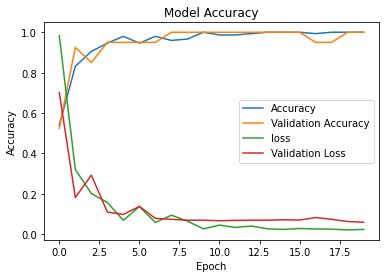

In [18]:
#Ploting Acuracy & Loss
import matplotlib.pyplot as plt
plt.plot(r.history['accuracy'])
plt.plot(r.history['val_accuracy'])
plt.plot(r.history['loss'])
plt.plot(r.history['val_loss'])
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])
plt.show()

In [19]:
#Save the model as h5 file
from tensorflow.keras.models import load_model
model.save('model_vgg16.h5')

# **Testing**

### Example 1

The Image detected is Normal


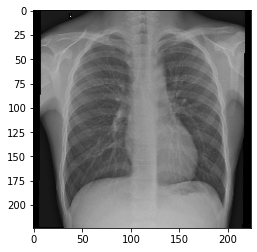

In [28]:
#Example 1

import numpy as np
from tensorflow.keras.preprocessing import image
test_image = image.load_img('/content/drive/MyDrive/AML/CNN/xray_dataset_covid19/test/NORMAL/NORMAL2-IM-0052-0001.jpeg', target_size = (224, 224))
imgplot = plt.imshow(test_image)
test_image = image.img_to_array(test_image)
test_image=test_image/255
test_image = np.expand_dims(test_image, axis = 0)
preds = model.predict(test_image)

preds = np.argmax(preds, axis=1)
if preds==0:
  print("The Image detected is Normal")
elif preds==1:
  print("The Image detected is having Pneumonia ")

### Example 2

The Image detected is having Pneumonia 


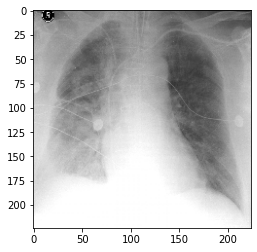

In [27]:
#Example 2

import numpy as np
from tensorflow.keras.preprocessing import image
test_image = image.load_img('/content/drive/MyDrive/AML/CNN/xray_dataset_covid19/test/PNEUMONIA/SARS-10.1148rg.242035193-g04mr34g0-Fig8b-day5.jpeg', target_size = (224, 224))
imgplot = plt.imshow(test_image)
test_image = image.img_to_array(test_image)
test_image=test_image/255
test_image = np.expand_dims(test_image, axis = 0)
preds = model.predict(test_image)
preds = np.argmax(preds, axis=1)
if preds==0:
  print("The Image detected is Normal")
elif preds==1:
  print("The Image detected is having Pneumonia ")